In [8]:
from google.colab import drive #import drive from google.colab
drive.mount('/content/drive') #mount google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
#Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [42]:
forecast_df = pd.read_excel('/content/drive/MyDrive/final_project/EML_forecast/forecast_data.xlsx')

In [43]:
#Dropping unnamed column from  dataframe
forecast_df = forecast_df.drop(columns=['Unnamed: 0'], axis=1)
print(forecast_df)

      Year      Country   Emission  Fertlizer_consumption  Temperature
0     1961  Afghanistan  2917273.5                   0.13    11.336061
1     1962  Afghanistan  2891160.8                   0.13    11.144664
2     1963  Afghanistan  2941533.2                   0.13    12.411098
3     1964  Afghanistan  3004207.0                   0.13    10.428792
4     1965  Afghanistan  3075739.0                   0.13    11.212704
...    ...          ...        ...                    ...          ...
7864  2017     Zimbabwe  5147235.0                  15.85    21.228878
7865  2018     Zimbabwe  5237749.0                  12.22    21.909628
7866  2019     Zimbabwe  5149571.5                  12.22    22.434425
7867  2020     Zimbabwe  4687377.5                   9.59    21.785597
7868  2021     Zimbabwe  4966384.0                   9.59    21.573135

[7869 rows x 5 columns]


In [44]:
#Removing all the entries where the Country name is World
forecast_df = forecast_df[forecast_df['Country']!='World']

In [52]:
#Creating a new dataframe group by Year and taking the average of NO2 emission,
#Fertilizer counsumption and Temerature
corr_df = forecast_df.groupby('Year')[['Emission', 'Fertlizer_consumption',
                                          'Temperature']].mean()
print(corr_df)

          Emission  Fertlizer_consumption  Temperature
Year                                                  
1961  8.489050e+06              14.736211    19.195658
1962  8.757632e+06              15.680742    19.009852
1963  9.042756e+06              16.729219    19.045872
1964  9.387130e+06              17.431719    18.986813
1965  9.769996e+06              18.166797    18.890422
...            ...                    ...          ...
2017  1.840855e+07              52.722031    20.343383
2018  1.829722e+07              51.806641    20.358923
2019  1.802809e+07              50.519258    20.509540
2020  1.808556e+07              53.520234    20.517973
2021  1.833325e+07              51.773203    20.404902

[61 rows x 3 columns]


In [53]:
#Resetting the index to transfrom Year as column
corr_df = corr_df.reset_index()
#Dropping the Year column for normalizing the data
corr_df_filter = corr_df.drop(columns = ['Year'], axis=1)

In [62]:
#Normalising data using MinMaxScaler and creating a new normalised datafraame
scaler = MinMaxScaler()
corr_df_norm = pd.DataFrame(scaler.fit_transform(corr_df_filter), columns = corr_df_filter.columns)
print(corr_df_norm)

    Emission  Fertlizer_consumption  Temperature
0   0.000000               0.000000     0.209277
1   0.027076               0.024354     0.098168
2   0.055820               0.051387     0.119707
3   0.090537               0.069500     0.084391
4   0.129134               0.088454     0.026750
..       ...                    ...          ...
56  1.000000               0.979419     0.895598
57  0.988776               0.955817     0.904891
58  0.961645               0.922623     0.994957
59  0.967439               1.000000     1.000000
60  0.992408               0.954955     0.932386

[61 rows x 3 columns]


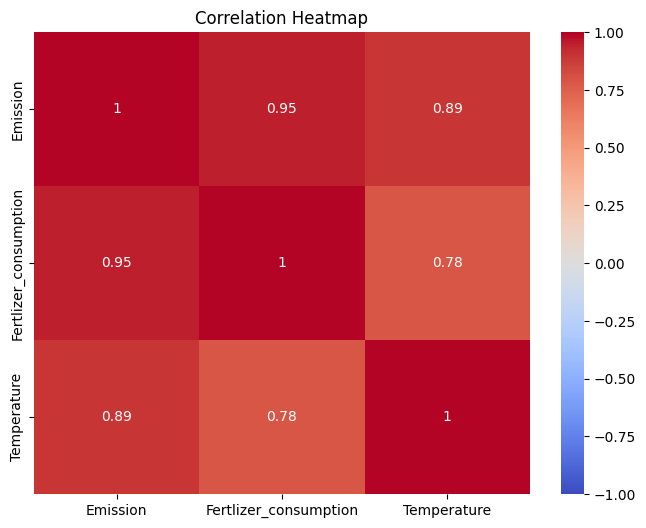

In [63]:
#Creating a correlation heatmap to explain the correlation between variables
corr_matrix = corr_df_norm.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

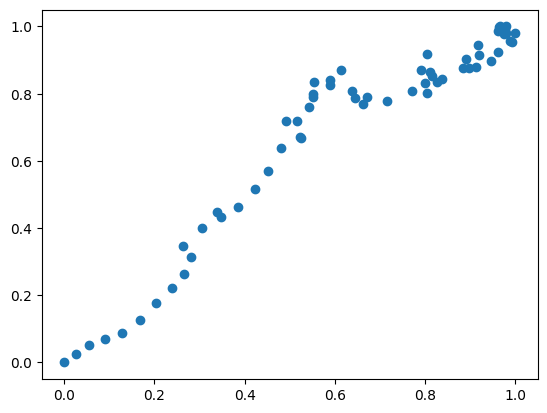

In [59]:
plt.figure()
plt.scatter(x=corr_df_norm['Emission'], y=corr_df_norm['Fertlizer_consumption'])
plt.show()

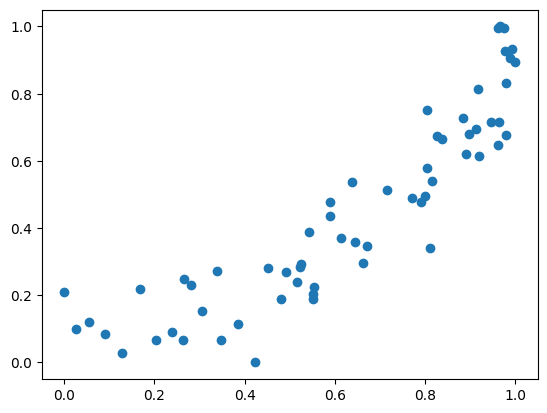

In [60]:
plt.figure()
plt.scatter(x=corr_df_norm['Emission'], y=corr_df_norm['Temperature'])
plt.show()